The code in this repository is largely based on the work of Olga Ratushniak and Svitlana Myroshnychenko during their MSc thesis. For more information, please contact Beatriz Cabrero-Daniel.

In [10]:
import csv
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import zCurve as z

In [11]:
def get_files_in_folder(folder_path):
    try:
        files = [folder_path + "/" + f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files

    except Exception as e:
        print(f"An error occurred while getting files in the folder: {str(e)}")
        return []
    
def remove_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
       file_path = os.path.join(folder_path, filename)
       if os.path.isfile(file_path):
          os.remove(file_path)
          # print(filename, "is removed")
            
            
def add_gaussian_noise(data, mean=0, std_factor=0.1):
    std_dev = std_factor * np.std(data) # Scale noise based on data variability
    noise = np.random.normal(mean, std_dev, size=data.shape)
    return data + noise

In [12]:
def calculate_morton(data_files, scales_dict, offsets_dict):
    data_files.sort()
    data_files.reverse()

    # ===============================
    # DATA FILE PROCESSING
    # ===============================
    for file_path in data_files:
        if ".csv" not in file_path:
            continue

        # print(file_path)

        # Get the file basename without extension
        file_basename = os.path.splitext(os.path.basename(file_path))[0]
        
        data = pd.read_csv(file_path, sep=";")
        data['timestamp'] = data['Time (seconds)'] + data['Time (microseconds)'] / (10**6)

        # Transformation for speed and steering angle 

        ntimestamps = len(data['timestamp'])
        ndimensions = len(scales_dict)
        tmp_matrix = np.zeros((ntimestamps, ndimensions))

        for j, data_key in enumerate(scales_dict.keys()):
            tmp_matrix[:, j] = [int(i) for i in data[data_key] * scales_dict[data_key] + offsets_dict[data_key]]

        # -------------------------------
        # Build Morton (Z-order) Index (if chosen or if building both)
        # -------------------------------
        data['Morton_Index'] = [z.interlace(int(x), int(y), bits_per_dim=10) for x, y in zip(tmp_matrix[:,0], tmp_matrix[:,1])]
        df = pd.DataFrame(data=data)
        df.to_csv(file_path, sep=";")

    return []

def plot_morton(data_files):
    common_figsize = (6,5)
    output_dir = "results/real_data/plots"  # Folder to save plots
    os.makedirs(output_dir, exist_ok=True)

    data_files.sort()
    data_files.reverse()

    # ===============================
    # DATA FILE PROCESSING
    # ===============================
    for file_path in data_files:
        if ".csv" not in file_path:
            continue

        # print(file_path)

        # Get the file basename without extension
        file_basename = os.path.splitext(os.path.basename(file_path))[0]
        data = pd.read_csv(file_path, sep=";")


        fig, ax1 = plt.subplots(figsize=common_figsize)
        ax1.eventplot(data['Morton_Index'],
                        orientation='horizontal',
                        colors=["lightgray"],
                        alpha=0.4,
                        lineoffsets=0.5)
        ax1.set_xlabel("Morton Index")
        ax1.set_ylim((0, 1))
        ax1.tick_params(axis='y',gridOn=False, label1On=False, label2On=False)

        ax2 = ax1.twinx()
        ax2.scatter(data['Morton_Index'],
                    data['timestamp'],
                    color='black',
                    s=0.5,
                    alpha=0.8,
                    label="Timestamps")

        ax2.set_ylabel("Timestamp (s)")

        # ax1.set_xlim(0, 2000000) #set once the CSPs are analysed!

        plt.title(f"Morton CSP plot, Speed and Steering angle:\n{file_basename}")
        ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.tight_layout()
        plot_morton_filename = os.path.join(output_dir, f"{file_basename}_speed_angle_morton.png")
        #plt.savefig(plot_morton_filename, bbox_inches="tight")

        plt.show()
        plt.close()

    return []

def plot_transformed_signals(data_files, scales_dict, offsets_dict):
    common_figsize = (6,5)
    output_dir = "results/real_data/plots"  # Folder to save plots
    os.makedirs(output_dir, exist_ok=True)

    data_files.sort()
    data_files.reverse()

    for file_path in data_files:
        if ".csv" not in file_path:
            continue

        # print(file_path)

        # Get the file basename without extension
        file_basename = os.path.splitext(os.path.basename(file_path))[0]
        data = pd.read_csv(file_path, sep=';')

        speed = [int(i) for i in data['Speed (m/s)'] * scales_dict['Speed (m/s)'] + offsets_dict['Speed (m/s)']]
        steering_angle = [int(i) for i in data['Steering angle (deg)'] * scales_dict['Steering angle (deg)'] + offsets_dict['Steering angle (deg)']]

        timestamps = data['timestamp']
        timestamps = timestamps.tolist()
        # Find the lane changes 
        fig, ax = plt.subplots(figsize = common_figsize)
        lanechanges = []
        tmp_vec = []
        for i, el in enumerate(timestamps):

            if i == len(timestamps) - 1:
                break

            if data['Lane change'].tolist()[i] == 0 and data['Lane change'].tolist()[i+1] == 1:
                tmp_vec.append(timestamps[i])

            if data['Lane change'].tolist()[i] == 1 and data['Lane change'].tolist()[i+1] == 0:
                tmp_vec.append(timestamps[i])
                lanechanges.append(np.copy(tmp_vec))
                tmp_vec = []
                
            
        for el in lanechanges:
            tmin, tmax = el[0], el[1]
            smin, smax = np.min([speed, steering_angle]), np.max([speed, steering_angle])
            ax.vlines(x=tmin, ymin=smin, ymax=smax, ls = '--', color = 'green')
            ax.vlines(x=tmax, ymin=smin, ymax=smax, ls = '--', color = 'red')

        ax.plot(timestamps, speed, label='Speed')
        ax.plot(timestamps, steering_angle, label='Steering angle')
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Transformed signals")
        ax.set_title(f"Transformed Signals:\n{file_basename}")
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        ax.legend(loc="upper right")

        plot2_filename = os.path.join(output_dir, f"{file_basename}_transformed.png")
        #plt.savefig(plot2_filename, bbox_inches="tight")
        plt.show()
        plt.close()
    
    return 

In [13]:
def generate_trajectory(examplename="", speedchange=0, angle=-1, numexamples=5, fixed_initialspeed=None, fixed_angle=None, num_points=2500, noise_amp=3):
    delta_t = 10**4  # Time step in microseconds
    for example in range(1,numexamples+1):
        filename = "results/synthetic_lanechangecitos/"+examplename+"_"+str(example)+".csv"
        
        window_size= 150
        noisy_amplitude = np.random.normal(0, noise_amp, num_points)
        noisy_amplitude = np.convolve(noisy_amplitude, np.ones(window_size)/window_size, mode='same')
        noisy_amplitude[0] = 0
        
        window_size= 100
        noisy_amplitude1 = np.random.normal(0, noise_amp*10, num_points)
        noisy_amplitude1 = np.convolve(noisy_amplitude1, np.ones(window_size)/window_size, mode='same')
        noisy_amplitude1[0] = 0
        
        timestamp = 0
        lanechange_progress = 0
        was_lane_change = 0
        initial_speed = fixed_initialspeed if fixed_initialspeed else (21.5 - example * 1.4) 
        steering_angle_amplitude = fixed_angle if fixed_angle else (20 + example * 2) 
        
        with (open(filename, mode='w', newline='') as file):
                writer = csv.writer(file, delimiter=';')
                writer.writerow(["Time (seconds)", "Time (microseconds)", "Speed (m/s)", "Steering angle (deg)", "Lane change"])
                
                for i in range(0, num_points):                    
                    islanechange = 0 if math.cos(timestamp*delta_t/10**10/2)>0 else 1
                    
                    if was_lane_change != islanechange: lanechange_progress = 0
                    elif islanechange: lanechange_progress += 1
                    
                    turning_angle = - math.sin(timestamp*delta_t/10**10) * (steering_angle_amplitude+(example if not fixed_angle else 0)) * islanechange * angle + noisy_amplitude1[i]
                    
                    was_lane_change = islanechange
                    islanechange = 0 if math.cos(timestamp*delta_t/10**10/2)>0.2 else 1
                    
                    speed = initial_speed + lanechange_progress / 40 * speedchange * (1 if not speedchange else (example+1)/2) + noisy_amplitude[i]
                    
                    writer.writerow([int(timestamp / 1000000), timestamp % 1000000, speed, turning_angle, islanechange])
                    timestamp += delta_t
            


In [14]:
remove_files_in_folder("results/synthetic_lanechangecitos/")

for dir in ["left", "right"]:
    generate_trajectory(examplename="lc"+dir+"_fixedspeed", speedchange=0, fixed_initialspeed=15, angle=-1 if dir == "left" else 1, noise_amp=0)
    generate_trajectory(examplename="lc"+dir+"_fixedmaxangle", speedchange=0, fixed_angle=30, angle=-1 if dir == "left" else 1, noise_amp=0)    
    generate_trajectory(examplename="lc"+dir+"_fixedmaxangle_speedup", speedchange=0.18, fixed_angle=30, fixed_initialspeed=15, angle=-1 if dir == "left" else 1, noise_amp=0)
    generate_trajectory(examplename="lc"+dir+"_fixedmaxangle_speeddown", speedchange=-0.18, fixed_angle=30, fixed_initialspeed=20.5, angle=-1 if dir == "left" else 1, noise_amp=0)


=== LCLEFT ===


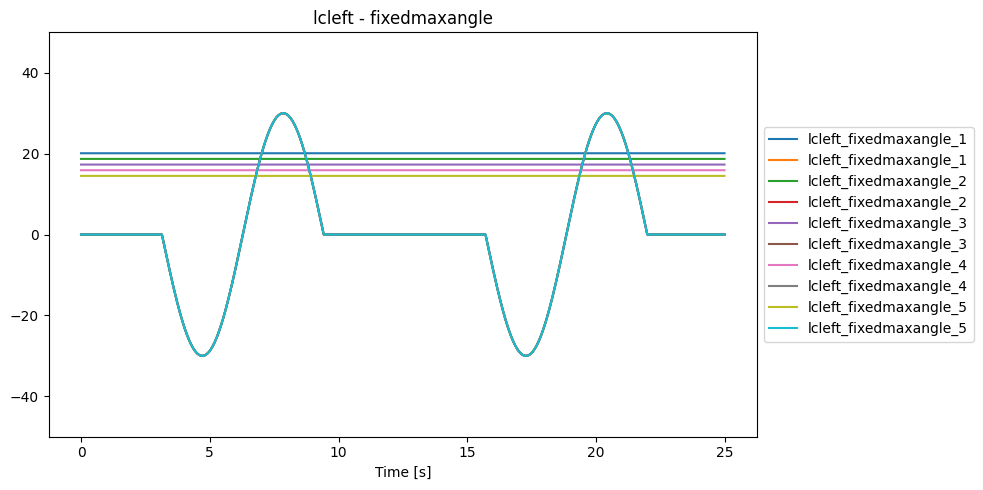

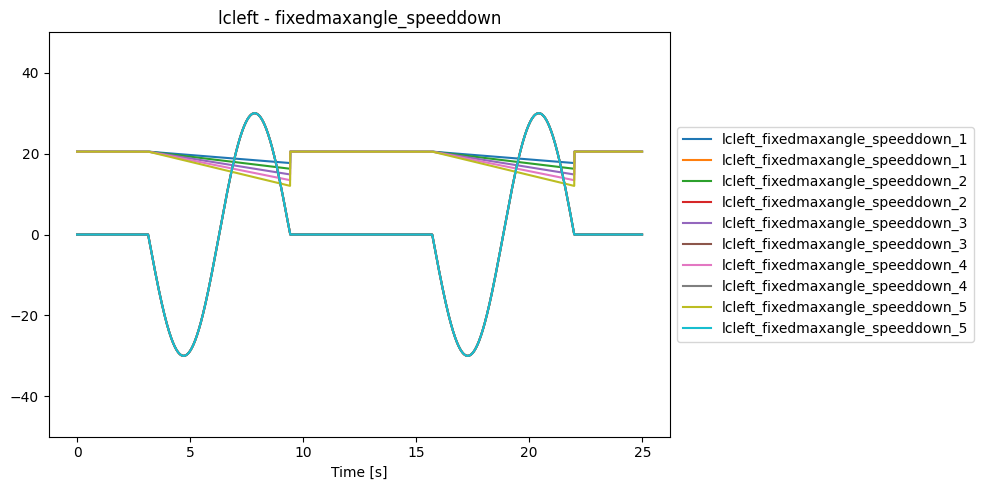

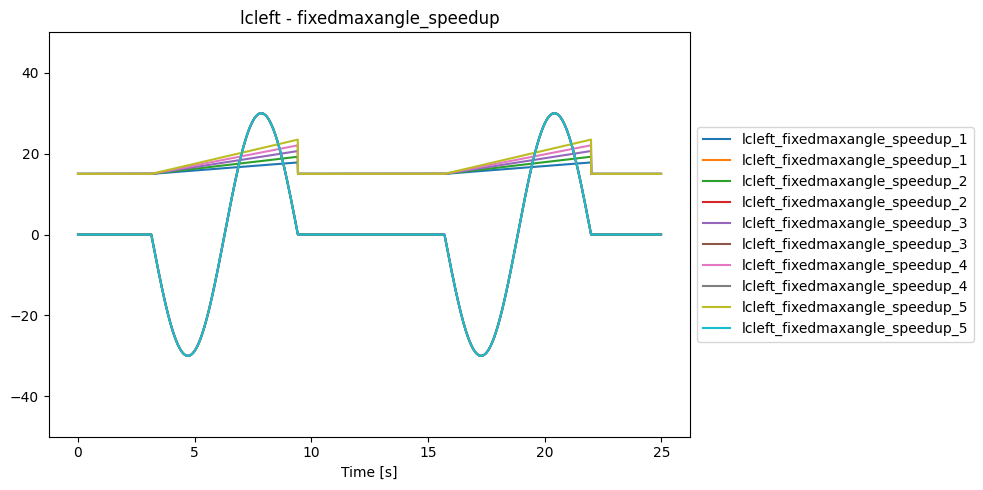

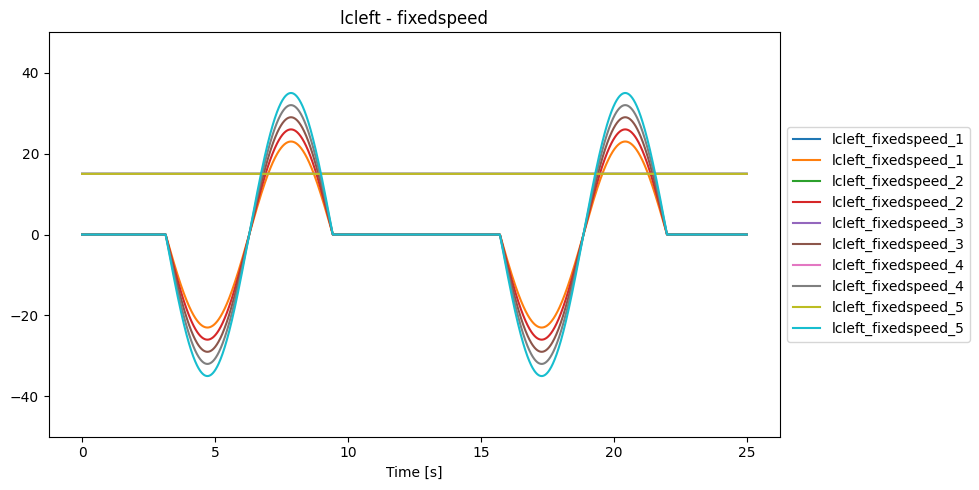


=== LCRIGHT ===


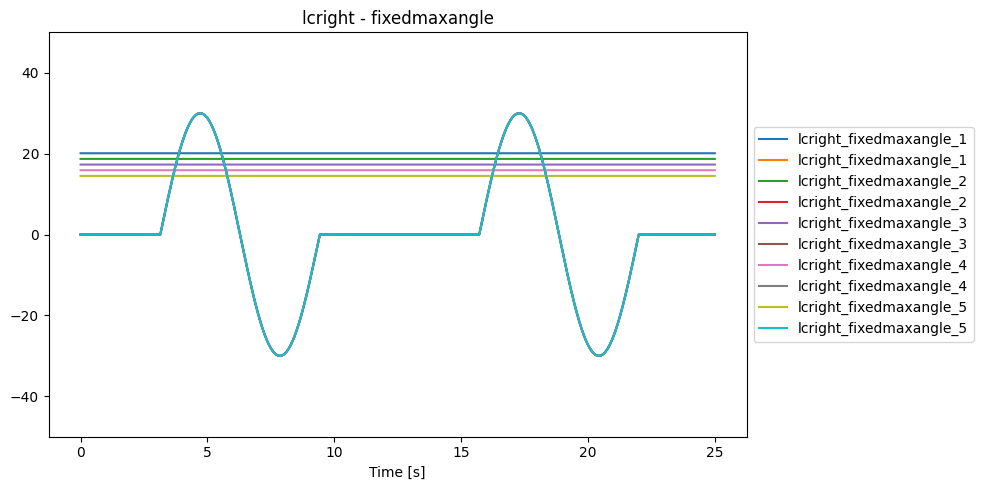

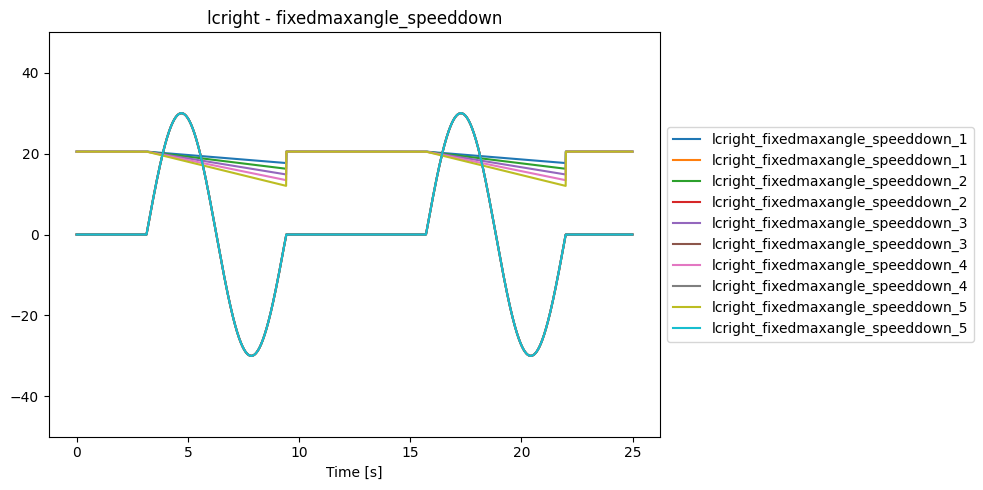

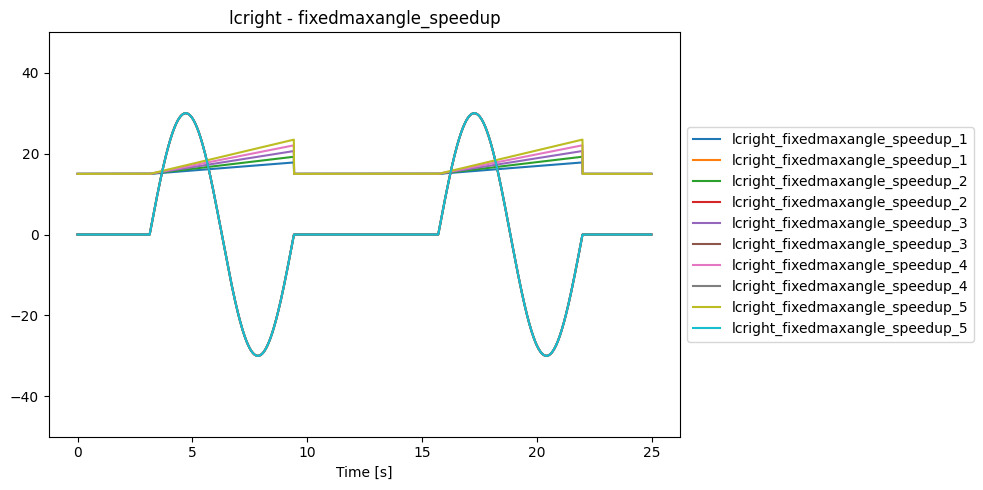

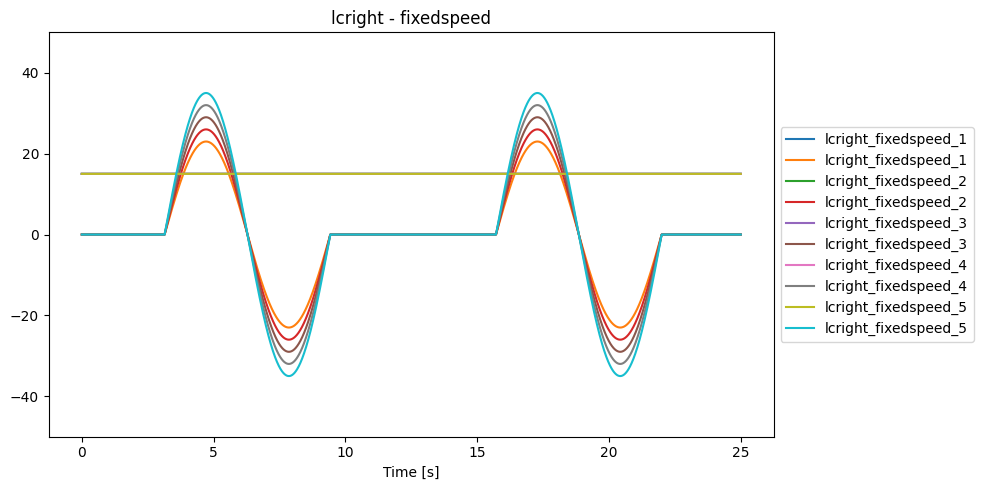

In [15]:
files = sorted(glob(os.path.join("results/synthetic_lanechangecitos/", "*.csv")))

# Group files by starting side (e.g., lcleft_ / lcright_)
grouped = {}
for f in files:
    base = os.path.basename(f)
    if not base.endswith(".csv"):
        continue

    # Extract start side and experiment type
    parts = base.replace(".csv", "").split("_")
    start = parts[0]  # lcleft or lcright
    exp_type = "_".join(parts[1:-1]) if len(parts) > 2 else parts[1]

    grouped.setdefault(start, {}).setdefault(exp_type, []).append(f)

# Plot each group separately
for start_side, exp_dict in grouped.items():
    print(f"\n=== {start_side.upper()} ===")
    for exp_name, file_list in exp_dict.items():
        fig, ax = plt.subplots(figsize=(10, 5))
        for f in file_list:
            data = pd.read_csv(f, sep=';')
            data['timestamp'] = data['Time (seconds)'] * 1_000_000 + data['Time (microseconds)']
            data['timestamp'] /= 1_000_000

            label = os.path.splitext(os.path.basename(f))[0]
            ax.plot(data['timestamp'], data['Speed (m/s)'], label=f"{label}")
            ax.plot(data['timestamp'], data['Steering angle (deg)'], label=f"{label}")

        ax.set_title(f"{start_side} - {exp_name}")
        ax.set_xlabel("Time [s]")
        ax.set_ylim([-50, 50])
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space for legend
        plt.show()

In [16]:
# Set transformation for speed and steering angle
offsets, scales = {"Speed (m/s)": 105}, {"Speed (m/s)": 4}
offsets["Steering angle (deg)"] = 150
scales["Steering angle (deg)"] = 1

# ===============================
# Calculate morton
# ===============================
parentFolder = 'results/synthetic_lanechangecitos'
data_files = get_files_in_folder(folder_path=parentFolder)
data_files.sort()
data_files.reverse()
calculate_morton(data_files=data_files,scales_dict=scales, offsets_dict=offsets)

[]

In [17]:
# ===============================
# Load Morton indices
# ===============================

file_basenames = []
csps = {}
csps_normalized = {}
speeds = {}
for file_path in data_files:
    if ".csv" not in file_path:
        continue

    # Get the file basename without extension
    file_basename = os.path.splitext(os.path.basename(file_path))[0]
    file_basenames.append(file_basename)

    data = pd.read_csv(file_path, sep=";")
    morton= np.array(data['Morton_Index'].tolist())
    morton_normalized = morton / np.sqrt(np.dot(morton, morton))

    csps[file_basename] = np.copy(morton)
    speeds[file_basename] = data['Speed (m/s)'].iloc[0]
    csps_normalized[file_basename] = np.copy(morton_normalized)
    
file_basenames.sort()

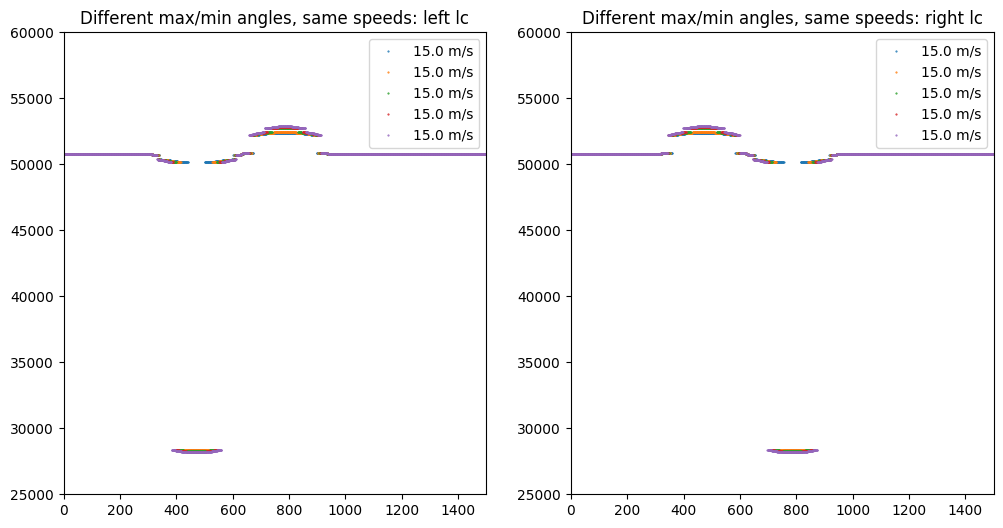

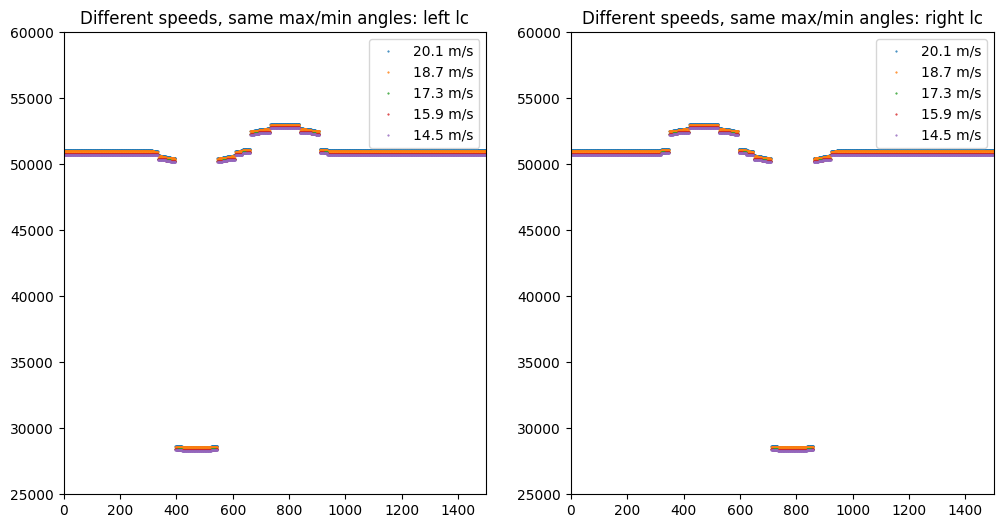

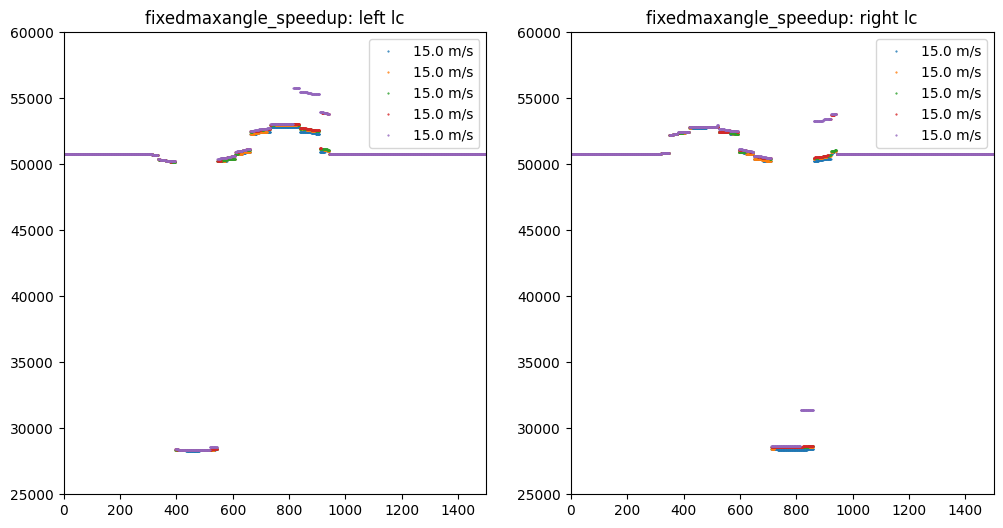

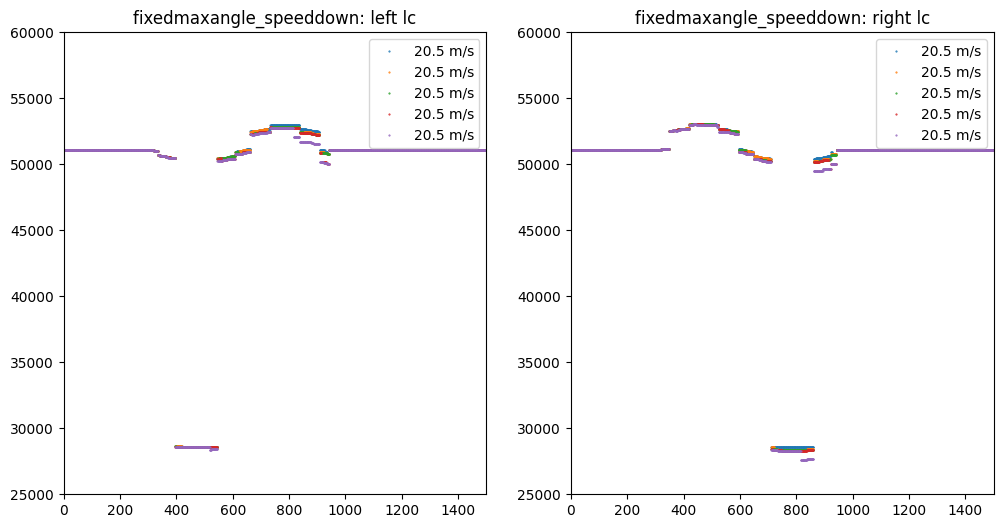

In [18]:
nrecords = 5
try:
    fig, ax = plt.subplots(ncols=2, figsize=(12,6))
    for i in range(1, nrecords + 1 ):
        left_lc = 'lcleft_' + 'fixedspeed' + f'_{i}'
        right_lc = 'lcright_' + 'fixedspeed' + f'_{i}'
    
        ax[0].plot(csps[left_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)
        ax[1].plot(csps[right_lc], label=f'{speeds[right_lc]} m/s', ls='none', marker='o', ms=0.5)
    
        ax[0].set_title('Different max/min angles, same speeds: left lc')
        ax[1].set_title('Different max/min angles, same speeds: right lc')
        ax[0].set_xlim(0,1500)
        ax[1].set_xlim(0,1500)
        ax[0].set_ylim(25000,60000)
        ax[1].set_ylim(25000,60000)
        ax[0].legend()
        ax[1].legend()
    plt.show()
except:
    pass

try:
    fig, ax = plt.subplots(ncols=2, figsize=(12,6))
    for i in range(1, nrecords +1):
        left_lc = 'lcleft_' + 'fixedmaxangle' + f'_{i}'
        right_lc = 'lcright_' + 'fixedmaxangle' + f'_{i}'
    
        ax[0].plot(csps[left_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)
        ax[1].plot(csps[right_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)
    
    
        ax[0].set_title('Different speeds, same max/min angles: left lc')
        ax[1].set_title('Different speeds, same max/min angles: right lc')
        ax[0].set_xlim(0,1500)
        ax[1].set_xlim(0,1500)
        ax[0].set_ylim(25000,60000)
        ax[1].set_ylim(25000,60000)
        ax[0].legend()
        ax[1].legend()
    plt.show()
except:
    pass

try:
    fig, ax = plt.subplots(ncols=2, figsize=(12,6))
    for i in range(1, nrecords + 1 ):
        left_lc = 'lcleft_' + 'fixedmaxangle_speedup' + f'_{i}'
        right_lc = 'lcright_' + 'fixedmaxangle_speedup' + f'_{i}'
    
        ax[0].plot(csps[left_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)
        ax[1].plot(csps[right_lc], label=f'{speeds[right_lc]} m/s', ls='none', marker='o', ms=0.5)
    
        ax[0].set_title('fixedmaxangle_speedup: left lc')
        ax[1].set_title('fixedmaxangle_speedup: right lc')
        ax[0].set_xlim(0,1500)
        ax[1].set_xlim(0,1500)
        ax[0].set_ylim(25000,60000)
        ax[1].set_ylim(25000,60000)
        ax[0].legend()
        ax[1].legend()
    plt.show()
except:
    pass

try:    
    fig, ax = plt.subplots(ncols=2, figsize=(12,6))
    for i in range(1, nrecords + 1 ):
        left_lc = 'lcleft_' + 'fixedmaxangle_speeddown' + f'_{i}'
        right_lc = 'lcright_' + 'fixedmaxangle_speeddown' + f'_{i}'
    
        ax[0].plot(csps[left_lc], label=f'{speeds[left_lc]} m/s', ls='none', marker='o', ms=0.5)
        ax[1].plot(csps[right_lc], label=f'{speeds[right_lc]} m/s', ls='none', marker='o', ms=0.5)
    
        ax[0].set_title('fixedmaxangle_speeddown: left lc')
        ax[1].set_title('fixedmaxangle_speeddown: right lc')
        ax[0].set_xlim(0,1500)
        ax[1].set_xlim(0,1500)
        ax[0].set_ylim(25000,60000)
        ax[1].set_ylim(25000,60000)
        ax[0].legend()
        ax[1].legend()
    plt.show()
except:
    pass